# Data validation

## Abstract

This notebook aims at validating the train & test data in terms of machine learning predictability.

More specifically, we will assess if there are any noticeable differences in the distributions of the variables used for modelling (features & target) across the different data sets (training & test sets).

In a nutshell, such validation phase is made to assess if the data in hands is representative - which is crucial for a trained model to generalize well on new data.

## Train/test split

The train/test split has been given by default.
<br>There is no mention of how such split has been made.

Given the cardinalities of the train & test sets, the train/test split is 70% / 30%.

## SweetViz profiling

From the data exploration of the training and test sets in the 1st notebook, we cannot find any noticeable difference between the potential features that will be used for modelling the `Purchase` label.

### Load data

In [1]:
import pandas as pd

train_data = pd.read_csv("gs://aliz-ml-spec-2022/demo-2/data/train.csv")
test_data = pd.read_csv("gs://aliz-ml-spec-2022/demo-2/data/test.csv")

## Feature distribution across train/test sets

For the potential features, let's plot their distributions on both the train & test sets taken separately.

Such features are:
- `User_ID`
- `Product_ID`
- `Gender`
- `Age`
- `Occupation`
- `Marital_Status`
- `City_Category`
- `Stay_In_Current_City_Years`
- `Product_Category_1`
- `Product_Category_2`
- `Product_Category_3`

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(rc={"figure.figsize":(12, 9)})
sns.set(style="darkgrid")

df_train = train_data.copy()
df_train["label"] = "train"
df_test = test_data.copy()
df_test["label"] = "test"
df = pd.concat([df_train, df_test], axis=0)

os.makedirs("../imgs/feature_distributions", exist_ok=True)

def trace_train_test(y):
    (df
    .groupby("label")[y]
    .value_counts(normalize=True)
    .mul(100)
    .rename("Percent")
    .reset_index()
    .pipe((sns.catplot, "data"), x=y, y="Percent", hue="label", kind="bar"))

    plt.title("{} - train vs. test sets".format(y))
    plt.savefig("../imgs/feature_distributions/{}.jpg".format(y), bbox_inches="tight")
    plt.show()

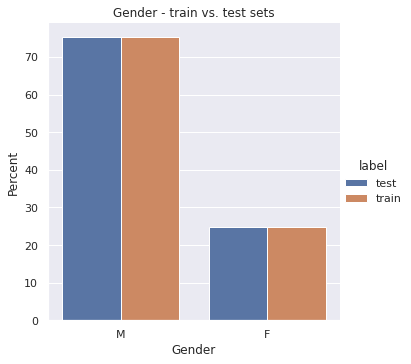

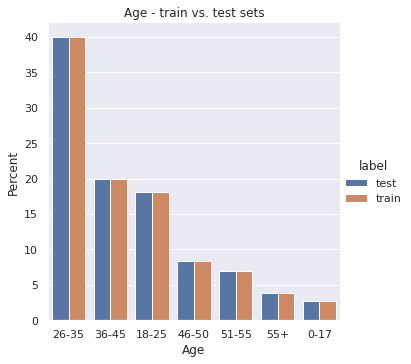

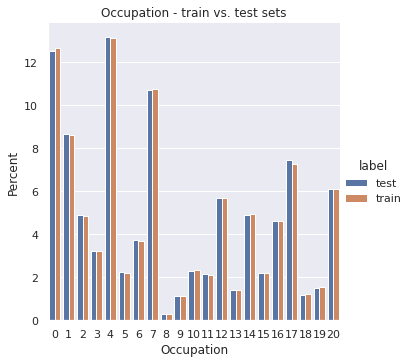

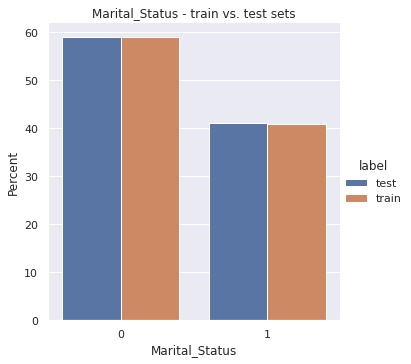

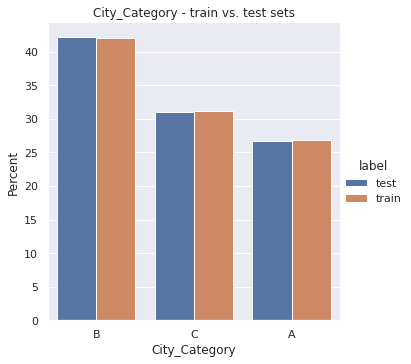

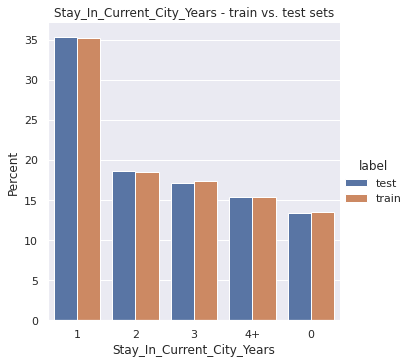

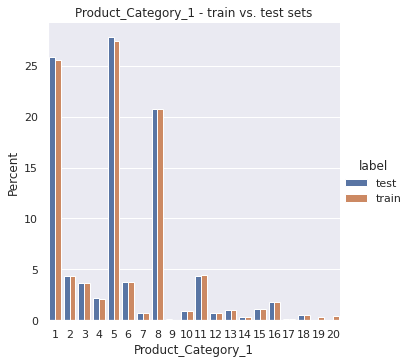

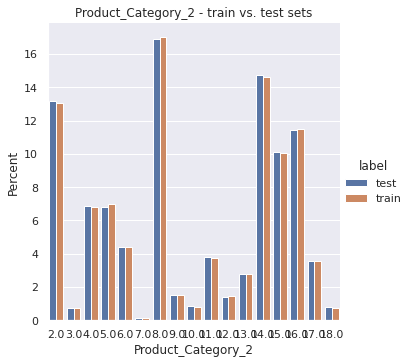

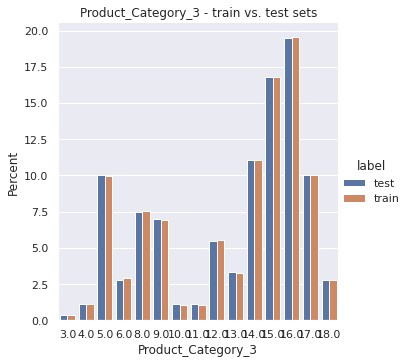

In [3]:
features = [
    # "User_ID",
    # "Product_ID",
    "Gender",
    "Age",
    "Occupation",
    "Marital_Status",
    "City_Category",
    "Stay_In_Current_City_Years",
    "Product_Category_1",
    "Product_Category_2",
    "Product_Category_3"
]

for feat_ in features:
    trace_train_test(feat_)

The distributions of each feature seem similar between the training & the test sets - except for `Product_Category_1` which misses 2 values in the test set (remark already formulated during the data exploration, first notebook.

Let's now look at the variables `User_ID` & `Product_ID`, more specifically check if all the feature values in the test set are also present in the training set.

In [4]:
unique_users_train = train_data["User_ID"].unique()
unique_users_test = test_data["User_ID"].unique()

user_anomalies = [u for u in unique_users_test if u not in unique_users_train]
n = len(user_anomalies)

print(f"Number of users present in test unseen during training: {len(user_anomalies)}")
if n != 0:
    N = len(unique_users_test)
    print(f"This represents a ratio of: {n/N :.4f}")

Number of users present in test unseen during training: 0


In [5]:
unique_products_train = train_data["Product_ID"].unique()
unique_products_test = test_data["Product_ID"].unique()

product_anomalies = [u for u in unique_products_test if u not in unique_products_train]
n = len(product_anomalies)

print(f"Number of products present in test unseen during training: {n}")
if n != 0:
    N = len(unique_products_test)
    print(f"This represents a ratio of: {n/N :.4f}")

Number of products present in test unseen during training: 46
This represents a ratio of: 0.0132


If all users present in the test set will be seen during training, this is not the case for the products since there will be 46 new products in the test, which represents 1% of all unique products in test.

This could possibly be a matter in terms of prediction performance but the encoding transform of the categorical feature will still work and handle unknown values.

Let's just check the exact proportion of the test examples with the unseen products.

In [6]:
N = test_data.shape[0]
n = test_data[test_data["Product_ID"].isin(product_anomalies)].shape[0]

print(f"Number of products present in test unseen during training: {n/N:.4f}")

Number of products present in test unseen during training: 0.0003


Only 0.03% of test examples do have unseen product IDs, which should not then be harmful for the prediction performance - except if their `Purchase` values are very high.

## Data drift detection with EvidentlyAI

In [7]:
from evidently.dashboard import Dashboard
from evidently.pipeline.column_mapping import ColumnMapping
from evidently.dashboard.tabs import DataDriftTab


column_mapping = ColumnMapping()
column_mapping.target = "Purchase"
column_mapping.categorical_features = features

ca_data_drift_dashboard = Dashboard(tabs=[DataDriftTab(verbose_level=0)])
ca_data_drift_dashboard.calculate(train_data.drop(columns=["Purchase"]), test_data, column_mapping=column_mapping)
ca_data_drift_dashboard.save("../reports/data_drift_dashboard.html")

In [8]:
# View evidendtly dashboard in Classic Jupyter view
# ca_data_drift_dashboard.show()

In [ ]:
from IPython.core.display import HTML

with open("../reports/data_drift_dashboard.html", encoding='utf8') as f:
    html = HTML(data="".join(f.readlines()))
html

On larger datasets EvidentlyAI checks the following distribution comparison metrics:
- **Wasserstein distance (normed)** on numeric features
- **Jensen-Shannon distance** on categorical features

Data drift is not detected by these tests.

## Conclusion

The train/test split is suitable for ML purposes.

If we consider the test set as future data, then the training set is representative of future data.

### Important note

Additional descriptive statistics extracted from the training & test sets could have been calculated to assess any shift, drift or skew in the features.

The most comprehensive way to assess any discrepancy between the train & test sets would be to run an __Adversarial Validation__ and discard any feature that can distinguish between the training & the test points. This technique combines the training and test data. Label them with say a 0 for the training data and a 1 for the test data, mix them up, then see if we are able to correctly re-identify them using a binary classifier.